In [ ]:
# Usaremos una base de datos de imágenes con dos clases: perros y gatos.

# El objetivo es diseñar redes neuronales de convolución para clasificar perros 
# de gatos. Este problema es mucho más complejo que los anteriores, ya que:
# 1) la cantidad de características visuales que comparten perros y gatos pueden
# ser altas; y 2) las imágenes pueden contener background común. Estas dos
# características hace difícil separa las imágenes.

# También probaremos una función de utilidad de tensorflow, con la cual no 
# necesitamos cargar todos los datos en memoria al mismo tiempo, sino que los 
# vamos cargando por lote (al vuelo). Con la ventaja adicional de que podemos
# crear variaciones sintéticas de ellos.

# Finalmente, veremos otras dos aplicaciones de CNN's

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.layers import Dense, Flatten, Concatenate
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD

from sklearn.model_selection import train_test_split

# Part 1: Download data and set directories

In [15]:

from my_path import my_path

In [16]:
# Download data from a website
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True, cache_dir=my_path)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

# List path contents
%ls "$PATH"

 Volume in drive C has no label.
 Volume Serial Number is 0C98-752C

 Directory of C:\Users\mateo\OneDrive - INSTITUTO TECNOLOGICO AUTONOMO DE MEXICO\Deep\data\datasets\cats_and_dogs_filtered

03/13/2023  12:34 AM    <DIR>          .
03/13/2023  12:34 AM    <DIR>          ..
03/13/2023  12:34 AM    <DIR>          train
03/13/2023  12:34 AM    <DIR>          validation
03/15/2023  12:41 AM               140 vectorize.py
               1 File(s)            140 bytes
               4 Dir(s)  248,376,324,096 bytes free


In [17]:
# Define paths to training and validation images
train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'validation')

# Specify them by class
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with training dog pictures
val_cats_dir = os.path.join(val_dir, 'cats')      # directory with validation cat pictures
val_dogs_dir = os.path.join(val_dir, 'dogs')      # directory with validation dog pictures

# Print example
print(train_cats_dir)

C:\Users\mateo\OneDrive - INSTITUTO TECNOLOGICO AUTONOMO DE MEXICO\Deep\data\datasets\cats_and_dogs_filtered\train\cats


In [18]:
# Count how many of them are there
n_cats_train = len(os.listdir(train_cats_dir))
n_dogs_train = len(os.listdir(train_dogs_dir))

n_cats_val = len(os.listdir(val_cats_dir))
n_dogs_val = len(os.listdir(val_dogs_dir))

n_total_train = n_cats_train + n_dogs_train
n_total_val = n_cats_val + n_dogs_val

# Print some info
print('total training cat images:', n_cats_train)
print('total training dog images:', n_dogs_train)

print('total validation cat images:', n_cats_val)
print('total validation dog images:', n_dogs_val)
print("--")
print("Total training images:", n_total_train)
print("Total validation images:", n_total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


# Part 2: Define data generators

In [19]:
# Define some constants
batch_size = 64
IMG_H = 128
IMG_W = 128

In [20]:
# Define generator objects for training and validation data.
# Generator objects will include controlled noise

# With added noise
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=5,
                                   width_shift_range=0.10, height_shift_range=0.10,
                                   shear_range=0.10, zoom_range=0.10, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255, rotation_range=5,
                                 width_shift_range=0.10, height_shift_range=0.10,
                                 shear_range=0.10, zoom_range=0.10,  horizontal_flip=True)

# Without noise (rescale is still need it, as pixel values have integer values
# between 0 and 255. after rescaling them, they have real values between 0 and 1).
#train_datagen = ImageDataGenerator(rescale=1./255)
#val_datagen = ImageDataGenerator(rescale=1./255)

In [21]:
# Define method to load images from disk, apply rescaling, and resize them into specified size.
train_generator = train_datagen.flow_from_directory(batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_H, IMG_W),
                                                class_mode='binary')
val_generator = val_datagen.flow_from_directory(batch_size=batch_size,
                                            directory=val_dir,
                                            target_size=(IMG_H, IMG_W),
                                            class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


(64, 128, 128, 3)
0.0
1.0
(64,)


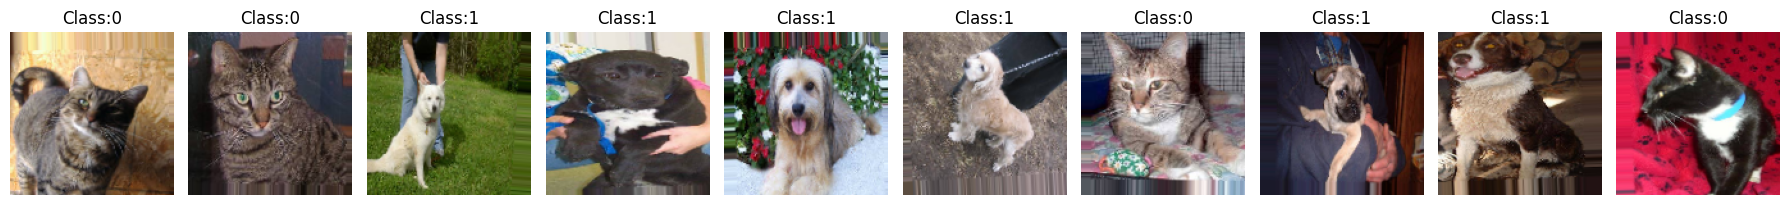

In [22]:
# This cell is just an example of a batch returned by the data generator
# The 'next()' function returns a batch from the dataset
sample_x, sample_y = next(train_generator)
print(sample_x.shape)
print(sample_x.min())
print(sample_x.max())
print(sample_y.shape)

# Show a few of them
fig, axes = plt.subplots(1, 10, figsize=(18, 5))
axes = axes.flatten()
for ind, (img, ax) in enumerate(zip(sample_x[:10], axes)):
  ax.imshow(img)
  ax.set_title("Class:" + str(int(sample_y[ind])))
  ax.axis('off')
plt.tight_layout()
plt.show()

# Part 3: Create CNN model and train it

In [23]:
# == Q1 ==
# Diseña una red CNN
# ¿Puedes lograr exactitud >= 0.8 en el set de validación?
# ¿Cuál es la pérdida asociada?
# ¿Cuántos parámetros tiene tu modelo?
# ¿Qué otros hiper-parámetros definiste?

In [24]:
# Create a CNN
CNN = Sequential([
    Input(shape=(IMG_H, IMG_W, 3)),
    
    Conv2D(filters=32, kernel_size=3, padding='same'),
    Conv2D(filters=32, kernel_size=1, padding='same'),
    LeakyReLU(),
    MaxPool2D(),

    Conv2D(filters=64, kernel_size=3, padding='same'),
    Conv2D(filters=64, kernel_size=1, padding='same'),
    LeakyReLU(),
    MaxPool2D(),

    Conv2D(filters=128, kernel_size=3, padding='same'),
    Conv2D(filters=128, kernel_size=1, padding='same'),
    LeakyReLU(),
    MaxPool2D(),

    Conv2D(filters=256, kernel_size=3, padding='same'),
    Conv2D(filters=256, kernel_size=1, padding='same'),
    LeakyReLU(),
    MaxPool2D(),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

CNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 conv2d_17 (Conv2D)          (None, 128, 128, 32)      1056      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 64)        4160      
                                                      

In [25]:
# Compile: Define training parameters
optim = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
CNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
# Train model
EPOCHS = 50
BATCHES = n_total_train//batch_size

CNN.fit(train_generator, steps_per_epoch=BATCHES, epochs=EPOCHS, validation_data=val_generator)

Epoch 1/50
31/31 [==============================] - 33s 1s/step - loss: 0.3348 - accuracy: 0.8507 - val_loss: 0.4901 - val_accuracy: 0.7860
Epoch 2/50
31/31 [==============================] - 33s 1s/step - loss: 0.3514 - accuracy: 0.8414 - val_loss: 0.4919 - val_accuracy: 0.7620
Epoch 3/50
31/31 [==============================] - 33s 1s/step - loss: 0.3504 - accuracy: 0.8435 - val_loss: 0.4208 - val_accuracy: 0.8090
Epoch 4/50
31/31 [==============================] - 33s 1s/step - loss: 0.3086 - accuracy: 0.8688 - val_loss: 0.4641 - val_accuracy: 0.7960
Epoch 5/50
31/31 [==============================] - 32s 1s/step - loss: 0.3056 - accuracy: 0.8657 - val_loss: 0.4809 - val_accuracy: 0.7910
Epoch 6/50
31/31 [==============================] - 33s 1s/step - loss: 0.3075 - accuracy: 0.8631 - val_loss: 0.4476 - val_accuracy: 0.8060
Epoch 7/50
31/31 [==============================] - 33s 1s/step - loss: 0.3153 - accuracy: 0.8585 - val_loss: 0.4640 - val_accuracy: 0.7990
Epoch 8/50
31/31 [==

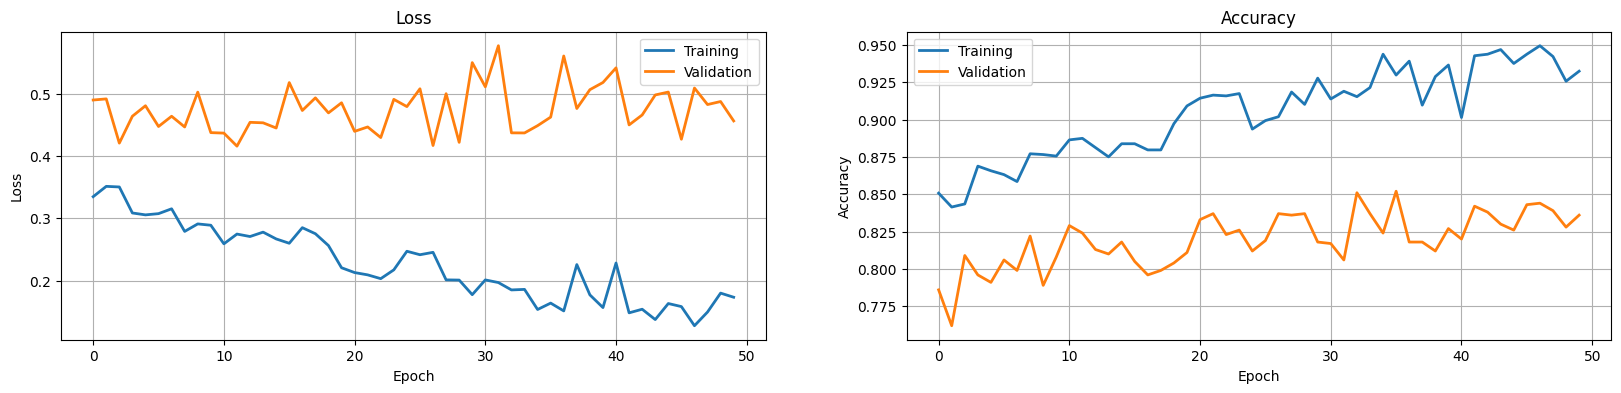

In [28]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(CNN.history.history['loss'], label='Training', linewidth=2)
plt.plot(CNN.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(CNN.history.history['accuracy'], label='Training', linewidth=2)
plt.plot(CNN.history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

# Part 4: Images as vectors

In [30]:
# Define generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [31]:
# Define method to load images from disk, apply rescaling, and resize them into specified size.
train_generator = train_datagen.flow_from_directory(batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_H, IMG_W),
                                                class_mode='binary')
val_generator = val_datagen.flow_from_directory(batch_size=batch_size,
                                            directory=val_dir,
                                            target_size=(IMG_H, IMG_W),
                                            class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [32]:
# Get a batch sample, just to see its shape
sample_x, sample_y = next(train_generator)
print(sample_x.shape)
print(sample_x.min())
print(sample_x.max())
print(sample_y.shape)

sample_x = np.reshape(sample_x, newshape=(len(sample_x), -1))
print(sample_x.shape)
print(sample_x.min())
print(sample_x.max())
print(sample_y.shape)

(64, 128, 128, 3)
0.0
1.0
(64,)
(64, 49152)
0.0
1.0
(64,)


In [33]:
# == Q2 ==
# Create MLP (only perceptrons) and repeat training
# Try to get your MLP with as many parameters as your best previous CNN
# ¿Puedes lograr exactitud >= 0.8 en el set de validación?
# ¿Cuál es la pérdida asociada?
# ¿Cuántos parámetros tiene tu modelo?
# ¿Qué otros hiper-parámetros definiste?

DNN = Sequential([
    Input(shape=(49152,)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

DNN.summary()
#no logra acercarse al CNN ni de cerca, tuvo un desepeño máximo de 60% de accuracy

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               12583168  
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12,626,945
Trainable params: 12,626,945


In [34]:
# Compile: Define training parameters
DNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
# Training code, step by step
EPOCHS = 50
BATCHES = n_total_train//batch_size
for e in range(EPOCHS):
  print(f'Epoch: {e+1:2d}', end='[')
  for batch in range(BATCHES):
    x_batch, y_batch = next(train_generator)
    x_batch = np.reshape(x_batch, newshape=(len(x_batch), -1))
    DNN.fit(x_batch, y_batch, verbose=0)
    print('=', end='')

  # At the end of the epoch, evaluate and print performance
  # on training batch
  x_batch, y_batch = next(train_generator)
  x_batch = np.reshape(x_batch, newshape=(len(x_batch), -1))
  loss, accuracy = DNN.evaluate(x_batch, y_batch, verbose=0)
  # on validation batch
  x_val_batch, y_val_batch = next(val_generator)
  x_val_batch = np.reshape(x_val_batch, newshape=(len(x_val_batch), -1))
  val_loss, val_accuracy = DNN.evaluate(x_val_batch, y_val_batch, verbose=0)
  # print
  print(f"] - loss: {loss:.4f} - accuracy: {accuracy:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy:.4f}")

Epoch:  1[===============================] - loss: 0.6933 - accuracy: 0.4844 - val_loss: 0.6944 - val_accuracy: 0.3594
Epoch:  2[===============================] - loss: 0.6938 - accuracy: 0.4062 - val_loss: 0.6928 - val_accuracy: 0.5469
Epoch:  3[===============================] - loss: 0.6924 - accuracy: 0.5938 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch:  4[===============================] - loss: 0.6935 - accuracy: 0.4531 - val_loss: 0.6926 - val_accuracy: 0.5781
Epoch:  5[===============================] - loss: 0.6926 - accuracy: 0.5781 - val_loss: 0.6929 - val_accuracy: 0.5312
Epoch:  6[===============================] - loss: 0.6928 - accuracy: 0.5469 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch:  7[===============================] - loss: 0.6931 - accuracy: 0.5312 - val_loss: 0.6933 - val_accuracy: 0.4375
Epoch:  8[===============================] - loss: 0.6932 - accuracy: 0.4844 - val_loss: 0.6932 - val_accuracy: 0.4688
Epoch:  9[===============================] - los

KeyError: 'loss'

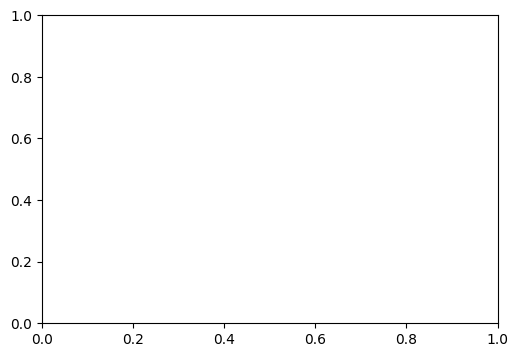

In [37]:
# Plot loss
plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
plt.plot(DNN.history.history['loss'], label='Training', linewidth=2)
plt.plot(DNN.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (mse)')
plt.grid()
plt.subplot(1, 3, 2)
plt.plot(DNN.history.history['mape'], label='Training', linewidth=2)
plt.plot(DNN.history.history['val_mape'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MAPE')
plt.grid()
plt.subplot(1, 3, 3)
plt.plot(DNN.history.history['r_square'], label='Training', linewidth=2)
plt.plot(DNN.history.history['val_r_square'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('r square')
plt.grid()
plt.show()

# Part 5: A new type of CNN

In [ ]:
from os import listdir
from os.path import join
from skimage.io import imread
from skimage.transform import resize

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Locate folder with dataset and check for existance of both dirs
!ls /content/drive/MyDrive/DataSets/LFW/

images	masks


In [ ]:
# Set paths to load images and masks
images_path = "/content/drive/MyDrive/DataSets/LFW/images/"
masks_path = "/content/drive/MyDrive/DataSets/LFW/masks/"

In [ ]:
# Load images
image_names = [f for f in listdir(images_path)]
X = np.array([resize(imread(join(images_path, f)), (128, 128)) for f in image_names])

print(X.shape)
print(X.min())
print(X.max())

(1000, 128, 128, 3)
0.0
1.0


In [ ]:
# Load masks
# (Uso los mismos nombres de archivos que para las imágenes, solo cambio el
# directorio y la extension)
Y = np.array([resize(imread(join(masks_path, f[:-3]+'ppm')), (128, 128)) for f in image_names])

print(Y.shape)
print(Y.min())
print(Y.max())

(1000, 128, 128, 3)
0.0
1.0


Images


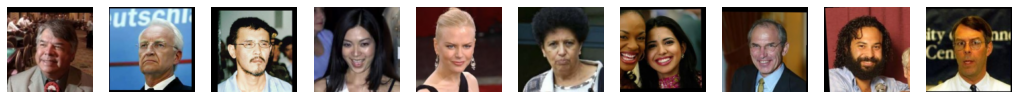

Masks


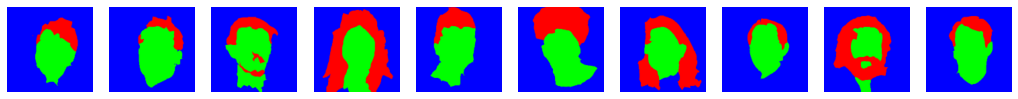

In [ ]:
# Show a few examples
print("Images")
plt.figure(figsize=(18, 3))
for ind, img in enumerate(X[:10]):
  plt.subplot(1, 10, ind+1)
  plt.imshow(img)
  plt.axis('off')
plt.show()

print("Masks")
plt.figure(figsize=(18, 3))
for ind, img in enumerate(Y[:10]):
  plt.subplot(1, 10, ind+1)
  plt.imshow(img)
  plt.axis('off')
plt.show()

In [ ]:
# Split train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(900, 128, 128, 3)
(900, 128, 128, 3)
(100, 128, 128, 3)
(100, 128, 128, 3)


In [ ]:
# == Q3 ==
# Considera la siguiente CNN's
# ¿Por qué tiene 3 filtros convolucionales en el último layer?
# Revisa la documentación de tensorflow. ¿cuál es la diferencia entre el layer
# Conv2D y Con2DTranspose?
# ¿Puedes lograr exactitud >= 0.93 en el set de validación?
# ¿Cuál es la pérdida asociada?
# ¿Cuántos parámetros tiene tu modelo?
# ¿Qué otros hiper-parámetros definiste?

In [ ]:
# # Lets create a CNN of type UNet
in_layer = Input(shape=(128, 128, 3))

conv1 = Conv2D(64, 3, padding='same', activation='relu')(in_layer)
conv1 = Conv2D(64, 3, padding='same', strides=2, activation='relu')(conv1)

conv2 = Conv2D(128, 3, padding='same', activation='relu')(conv1)
conv2 = Conv2D(128, 3, padding='same', strides=2, activation='relu')(conv2)

conv3 = Conv2D(256, 3, padding='same', activation='relu')(conv2)
conv3 = Conv2D(256, 3, padding='same', strides=2, activation='relu')(conv3)

conv4 = Conv2D(512, 3, padding='same', activation='relu')(conv3)

conc5 = Concatenate(axis=3)([conv4, conv3])
conv5 = Conv2DTranspose(256, 3, padding='same', strides=2, activation='relu')(conc5)
conv5 = Conv2D(256, 3, padding='same', activation='relu')(conv5)
# Conv2Transpose puede ser reemplazado por Conv2D + UpSampling2D

conc6 = Concatenate(axis=3)([conv5, conv2])
conv6 = Conv2DTranspose(128, 3, padding='same', strides=2, activation='relu')(conc6)
conv6 = Conv2D(128, 3, padding='same', activation='relu')(conv6)

conc7 = Concatenate(axis=3)([conv6, conv1])
conv7 = Conv2DTranspose(64, 3, padding='same', strides=2, activation='relu')(conc7)
conv7 = Conv2D(64, 3, padding='same', activation='relu')(conv7)

out_layer = Conv2D(3, 5, padding='same', activation='sigmoid')(conv7)

UNet = Model(in_layer, out_layer)
UNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   36928       ['conv2d[0][0]']                 
                                                                                              

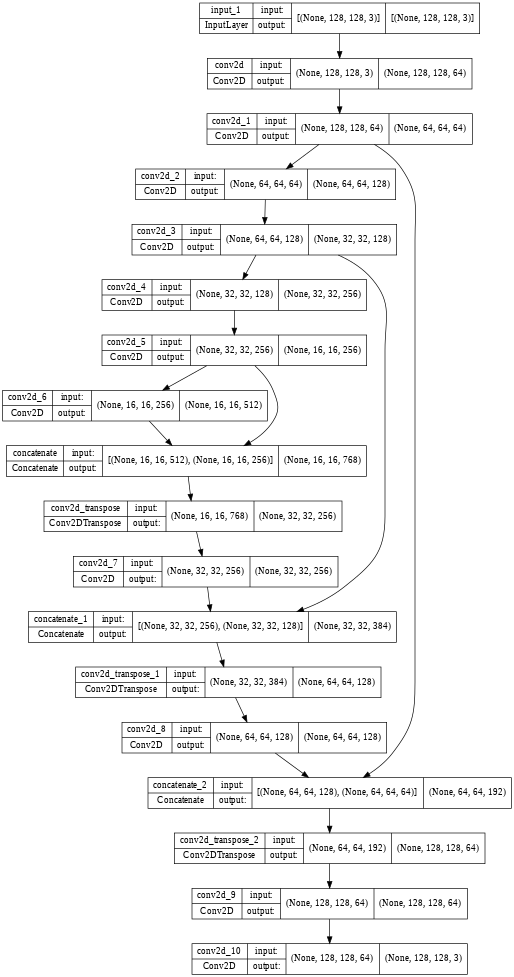

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(UNet, to_file='model.png', show_shapes=True, show_layer_names=True, dpi=48)

In [ ]:
# Compile and train it
UNet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
UNet.fit(x_train, y_train, batch_size=64, epochs=30, validation_split=0.2)

Epoch 1/30
12/12 [==============================] - 30s 1s/step - loss: 0.6645 - accuracy: 0.6165 - val_loss: 0.5894 - val_accuracy: 0.6675
Epoch 2/30
12/12 [==============================] - 6s 480ms/step - loss: 0.5327 - accuracy: 0.6618 - val_loss: 0.4530 - val_accuracy: 0.6678
Epoch 3/30
12/12 [==============================] - 6s 484ms/step - loss: 0.4361 - accuracy: 0.6621 - val_loss: 0.4028 - val_accuracy: 0.6678
Epoch 4/30
12/12 [==============================] - 6s 483ms/step - loss: 0.3920 - accuracy: 0.6624 - val_loss: 0.3614 - val_accuracy: 0.7701
Epoch 5/30
12/12 [==============================] - 6s 486ms/step - loss: 0.3350 - accuracy: 0.7844 - val_loss: 0.2818 - val_accuracy: 0.8193
Epoch 6/30
12/12 [==============================] - 6s 487ms/step - loss: 0.2880 - accuracy: 0.8085 - val_loss: 0.2536 - val_accuracy: 0.8484
Epoch 7/30
12/12 [==============================] - 6s 496ms/step - loss: 0.2537 - accuracy: 0.8446 - val_loss: 0.2542 - val_accuracy: 0.8444
Epoch 8/

In [ ]:
# Evaluate on test set
UNet.evaluate(x_test, y_test)

4/4 [==============================] - 3s 345ms/step - loss: 0.1475 - accuracy: 0.9115


[0.1474912017583847, 0.9115325808525085]

RGB input -- Test set


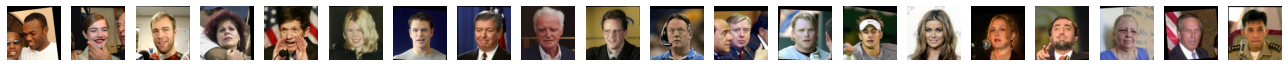

Mask output - Ground Truth -- Test set


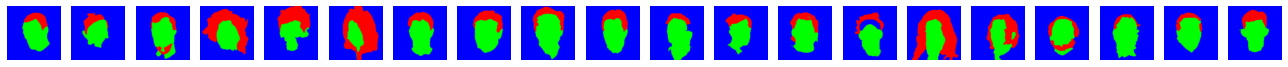

Prediction: binary -- Test set


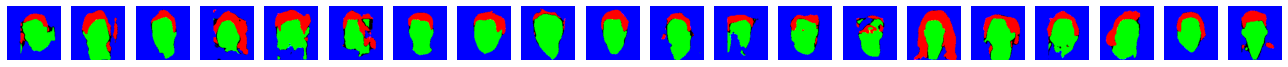

Prediction: probability -- Test set


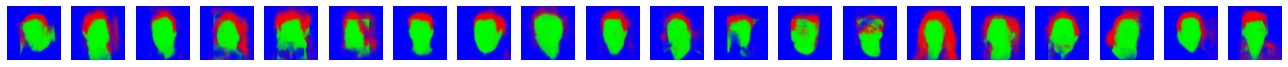

In [ ]:
# Show some predictions
y_test_hat = UNet.predict(x_test)

rand_ID = np.random.randint(0, len(x_test), 20) # Rand selection of images

print("RGB input -- Test set")
plt.figure(figsize=(18, 4))
for ind in range(20):
  plt.subplot(1, 20, ind+1)
  plt.imshow(x_test[rand_ID[ind]])
  plt.axis('off')
plt.tight_layout()
plt.show()

print("Mask output - Ground Truth -- Test set")
plt.figure(figsize=(18, 4))
for ind in range(20):
  plt.subplot(1, 20, ind+1)
  plt.imshow(y_test[rand_ID[ind]])
  plt.axis('off')
plt.tight_layout()
plt.show()

print("Prediction: binary -- Test set")
plt.figure(figsize=(18, 4))
for ind in range(20):
  plt.subplot(1, 20, ind+1)
  plt.imshow(y_test_hat[rand_ID[ind]].round())
  plt.axis('off')
plt.tight_layout()
plt.show()

print("Prediction: probability -- Test set")
plt.figure(figsize=(18, 4))
for ind in range(20):
  plt.subplot(1, 20, ind+1)
  plt.imshow(y_test_hat[rand_ID[ind]])
  plt.axis('off')
plt.tight_layout()
plt.show()

# Part 6: Yet another type of CNN

In [ ]:
# Importa los dígitos MNIST
# == Q4 ==
# Revisa las celdas de esta sección.
# Explica por qué crees que, al importar las imágenes, las asignamos a una
# variable llamada 'y' (en vez de 'x' como lo hicimos en la tarea anterior).
from tensorflow.keras.datasets import mnist
(y_train, _), (y_test, _) = mnist.load_data() # puedes revisar la documentación
# de la base de datos MNIST

# Dividimos entre 255 para tener pixeles con valores entre 0 y 1.
y_train = y_train / 255.
y_test  = y_test  / 255.

# Hacemos reshape, ya que las CNN requieren conocer explícitamente el número de
# canales de las imágenes. 1 canal en caso de imágenes binarias y grises.
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], y_train.shape[2], 1))
y_test  = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], y_test.shape[2], 1))

print("Shapes")
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
Shapes
y_train: (60000, 28, 28, 1)
y_test: (10000, 28, 28, 1)


In [ ]:
# == Q5 ==
# Aquí defino una funión. ¿Puedes explica qué es lo que hace?
from skimage.transform import resize

def noisy_resize(img):
  img = resize(img, (7, 7))
  for row in range(7):
    for col in range(7):
      if np.random.rand() > 0.9:
        img[row, col] = np.abs(img[row, col] - 1)
  return img

In [ ]:
# Ahora sí genero x (señales de entrada)
x_train = np.array([noisy_resize(img) for img in y_train])
x_test  = np.array([noisy_resize(img) for img in y_test ])

print("Shapes")
print("x_train:", x_train.shape)
print("x_test:", x_test.shape)

Shapes
x_train: (60000, 7, 7, 1)
x_test: (10000, 7, 7, 1)


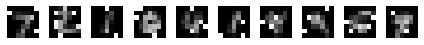

In [ ]:
# Show a few examples of X
for ind, img in enumerate(x_test[:10]):
  plt.subplot(1, 10, ind+1)
  plt.imshow(img[:,:,0], cmap='gray')
  plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Create a CNN (Notice there is no InputLayer)
CNN = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', input_shape=x_train.shape[1:]),
    Conv2D(32, 3, padding='same', activation='relu'),
    UpSampling2D(),

    Conv2D(32, 3, padding='same', activation='relu'),
    Conv2D(32, 3, padding='same', activation='relu'),
    UpSampling2D(),

    Conv2D(32, 3, padding='same', activation='relu'),
    Conv2D(1, 3, padding='same', activation='sigmoid'),
])

CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 7, 7, 32)          320       
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 32)          9248      
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 up_sampling2d_3 (UpSampling  (None, 28, 28, 32)       0         
 2D)                                                  

In [ ]:
# Compile and train
CNN.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['binary_accuracy'])
history = CNN.fit(x=x_train, y=y_train, batch_size=64, epochs=20, validation_split=0.1)

Epoch 1/20
844/844 [==============================] - 11s 12ms/step - loss: 0.3595 - binary_accuracy: 0.8047 - val_loss: 0.2411 - val_binary_accuracy: 0.7884
Epoch 2/20
844/844 [==============================] - 10s 12ms/step - loss: 0.2167 - binary_accuracy: 0.7840 - val_loss: 0.2010 - val_binary_accuracy: 0.7887
Epoch 3/20
844/844 [==============================] - 10s 12ms/step - loss: 0.1903 - binary_accuracy: 0.7905 - val_loss: 0.1889 - val_binary_accuracy: 0.7843
Epoch 4/20
844/844 [==============================] - 10s 12ms/step - loss: 0.1790 - binary_accuracy: 0.7933 - val_loss: 0.1736 - val_binary_accuracy: 0.7933
Epoch 5/20
844/844 [==============================] - 10s 11ms/step - loss: 0.1709 - binary_accuracy: 0.7951 - val_loss: 0.1675 - val_binary_accuracy: 0.7994
Epoch 6/20
844/844 [==============================] - 10s 12ms/step - loss: 0.1644 - binary_accuracy: 0.7967 - val_loss: 0.1604 - val_binary_accuracy: 0.7965
Epoch 7/20
844/844 [==============================] 

Noisy


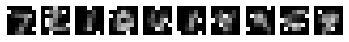

Predicted


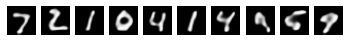

Original


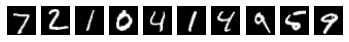

In [ ]:
# Predict on the test set, and plot a few examples
y_test_hat = CNN.predict(x_test[:10])

print("Noisy")
for ind, img in enumerate(x_test[:10]):
  plt.subplot(1, 10, ind+1)
  plt.imshow(img[:,:,0], cmap='gray')
  plt.axis('off')
plt.show()

print("Predicted")
for ind, img in enumerate(y_test_hat):
  plt.subplot(1, 10, ind+1)
  plt.imshow(img[:,:,0], cmap='gray')
  plt.axis('off')
plt.show()

print("Original")
for ind, img in enumerate(y_test[:10]):
  plt.subplot(1, 10, ind+1)
  plt.imshow(img[:,:,0], cmap='gray')
  plt.axis('off')
plt.show()

In [ ]:
# == Q6 ==
# ¿Qué problema está resolviendo esta red?

# == Q7 ==
# ¿Puedes mejorar el modelo para aumentar la exactitud a más de 0.95?
# Reporta el modelo resultante.